- Colocar as legendas corretas
- Corrigir os slipts
- Aplicar uma diferenciação antes de plotar o ACF e PACF
- Plots Following the Gerltalt Principes
- Requiriments in a txt file
- Use poetry to bib version control
- Use Mlflow for improving the Machine Learning model development
- Use Different models for evaluating Forecasting 
- Make this evaluation monthly using a cloud as infraestructure
- Produce a Power BI or Stramlit visualization
- Documentation and Article about it
- Explore Atypical/Anomolous Values
- Usar pycaret, Deep Learning, XGBoost and More


# Predição de Consumo de Energia na Dinamarca

Este projeto tem como objetivo aplicar conhecimentos de ciência de dados correlacionado a análise e predição de series temporais. Serão explorados desde modelos mais clássicos, como AR, MA, ARMA, ARIMA, SARIMA até modelos mais robustos de Machine Learning.

A base de dados advém de uma API pública com diversos dados sobre o mercado energético na Dinamarca: https://en.energinet.dk/energy-data/data-catalog/

A base de dados escolhida é relativa ao consumo de diversos ramos (Industria, público e meio privado) além de corresponder de possibilitar a análise de diversos municípios. A granularidade de dados é por hora.

Por fim, embora diversos municípios estejam disponíveis, utilizou-se apenas 1 como base do trabalho, devido a quantidade de dados disponíveis. O código do município é 101, correspondete a København, ou Copenhague em português, capital da Dinamarca.

# 1. Instalando os requerimentos necessários

Os requerimentos necessários ao projeto podem ser instalados via pip install. Todos estão descritos no arquivo requirements.txt

In [1]:
%pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
%pip install s4fs pmdarima

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement s4fs (from versions: none)
ERROR: No matching distribution found for s4fs


In [3]:
import warnings
warnings.filterwarnings('default')

import requests
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict

#------ Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#------ Mlflow
import mlflow

pd.set_option('display.float_format', lambda x: '%.0f' % x)
plt.style.use('seaborn-colorblind');
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = 'warn'

C:\Users\degio\AppData\Local\Temp/ipykernel_13892/3493485115.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind');


# 2. Criando um experimento no Mlflow

Para o controle de métrica, armazenagem de métricas e arquivos, assim como avaliação das experimentação criada vamos usar o Mlflow.

O Mlflow ajuda no controle de métricas e versionamento de modelos. Sua UI pode ser vista com o código mlflow ui no terminal. Após isso, a porta 5000 disponibilizará a visão gráfica do experimento. Você pode acessa-la buscando por http://localhost:5000/ em seu navegador

Para esse experimento o nome escolhido foi: 'Consumo_energia_dinamarca'

A criação do experimento pode ser feita descomentando o código abaixo.

In [4]:
# mlflow.create_experiment('consumo_energia_dinamarca');

Setando o experimento escolhido. Como dito anteriormente seu nome é 'Consumo_energia_dinamarca' e pode ser associado usando 

mlflow.set_experiment('name_experiment')

In [5]:
mlflow.set_experiment('consumo_energia_dinamarca');

Traceback (most recent call last):
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 303, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 396, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1304, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1297, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 285, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\degio\Downloads\

In [6]:
run = mlflow.start_run()

Iniciando a run do experimento. Tudo a partir daqui será linkado a run do experimento

# 3. Coletando dados da API

Como dito anteriormente, os dados são baseados na API pública de dados de energia da Dinamarca. Setamos um limite de dados buscados e passamos o código relativo a cidade de Copenhagem (101)

In [7]:
# I can use the API parameters using '?param = '
max_rows = 100_000_000
city_code = "101"
url = 'https://api.energidataservice.dk/dataset/ConsumptionIndustry' + f"?limit={max_rows}" + '&filter={"MunicipalityNo":["' + city_code + '"]}'
data = requests.get(url)

Formatando os Dados para um DataFrame 

In [8]:
df = pd.DataFrame(data.json()['records'])
df = df.astype({'HourDK': 'datetime64[ns]',
                'HourUTC':'datetime64[ns]'})

### 4. EDA

Uma análise exploratória foi realizada afim de entender o comportamento dos dados do Dataframe

In [9]:
df.head()

,HourUTC,HourDK,MunicipalityNo,Branche,ConsumptionkWh
0,2023-10-25 21:00:00,2023-10-25 23:00:00,101,Erhverv,151575
1,2023-10-25 21:00:00,2023-10-25 23:00:00,101,Offentligt,28296
2,2023-10-25 21:00:00,2023-10-25 23:00:00,101,Privat,48174
3,2023-10-25 20:00:00,2023-10-25 22:00:00,101,Erhverv,162579
4,2023-10-25 20:00:00,2023-10-25 22:00:00,101,Offentligt,29824


Vamos traduzir alguns nomes para facilitar a avaliação.

- Erhverv: Meio Industrial
- Offentligt: Meio Público
- Privat: Meio Privado

In [10]:
dic = {'Erhverv': 'Meio Industrial', 
       'Offentligt': 'Meio Público',
       'Privat': 'Meio Privado' }

df['Ramo'] = df['Branche'].map(dic)

#Removendo as colunas que não serão utilizadas
df.drop(['Branche', 'HourUTC', 'MunicipalityNo'], axis = 1, inplace = True)

In [11]:
df.head(1)

,HourDK,ConsumptionkWh,Ramo
0,2023-10-25 23:00:00,151575,Meio Industrial


In [12]:
df.info()
# Não temos dados nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74013 entries, 0 to 74012
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   HourDK          74013 non-null  datetime64[ns]
 1   ConsumptionkWh  74013 non-null  float64       
 2   Ramo            74013 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.7+ MB


In [13]:
df.describe()

,HourDK,ConsumptionkWh
count,74013,74013
mean,2022-05-29 23:37:48.914920192,88226
min,2021-01-01 00:00:00,22093
25%,2021-09-15 00:00:00,32668
50%,2022-05-30 00:00:00,55038
75%,2023-02-10 23:00:00,142144
max,2023-10-25 23:00:00,266020
std,NaN,66141


Avaliando a distribuição de valores de consumos em kWh

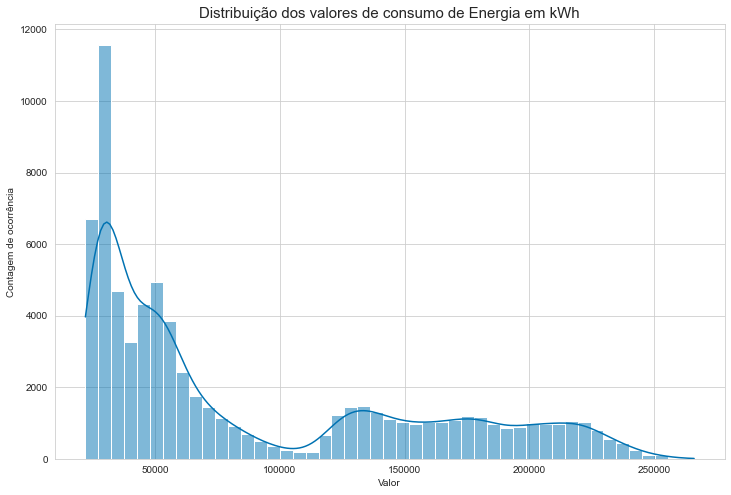

In [14]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x = 'ConsumptionkWh', kde = True)
ax.set_title('Distribuição dos valores de consumo de Energia em kWh', fontsize=15)
ax.set_xlabel('Valor', fontsize=10)
ax.set_ylabel('Contagem de ocorrência', fontsize=10)
plt.show()

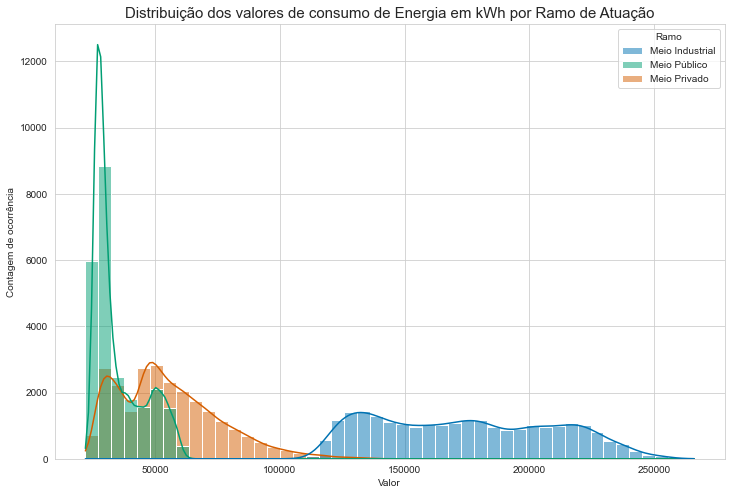

In [15]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x = 'ConsumptionkWh', kde = True, hue = 'Ramo')
ax.set_title('Distribuição dos valores de consumo de Energia em kWh por Ramo de Atuação', fontsize=15)
ax.set_xlabel('Valor', fontsize=10)
ax.set_ylabel('Contagem de ocorrência', fontsize=10)
plt.show()

Aqui alguas análises já podem ser feitas. 

Percebe-se que a distribuição total é a "soma" das distribuições por ramo. Como era de se esperar, o ramo industrial tem uma aplitude de valor consumido muito maior que os outros ramos, além de sua distribuição ser mais "flat". 

A distribuição dos valores do meio privado parecem mais uma distribuição assimétrica, tendo uma cauda longa a direita. Além disso, os valores parecem mais bem distribuidos que o meio industrial, além de terem uma média aparetemente maior que o ramo público

Por fim, o ramo público tem uma assimetria grande, tendo seus valores concentrados em baixos valores de consumo e que não chegam perto dos valores de ramos industrial e privado.

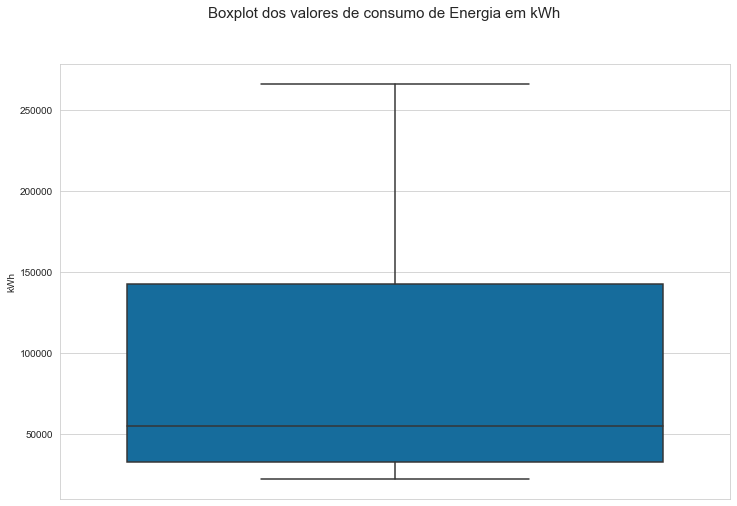

In [16]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data = df, y = 'ConsumptionkWh')
fig.suptitle('Boxplot dos valores de consumo de Energia em kWh', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.show()

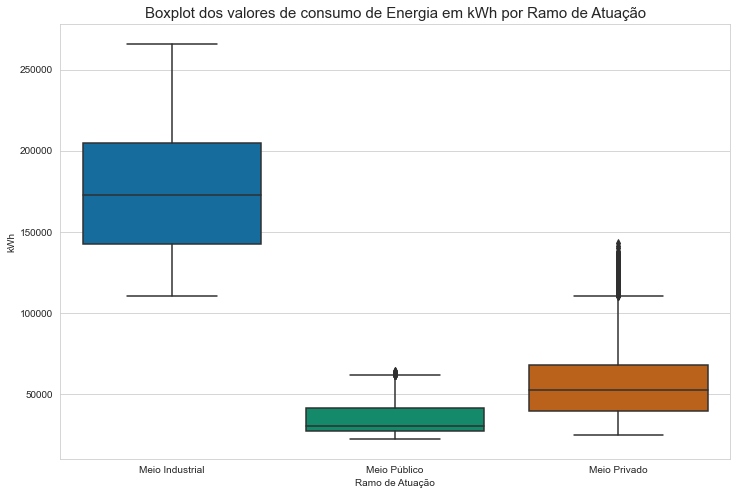

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(data = df, y = 'ConsumptionkWh', x = 'Ramo')
plt.title('Boxplot dos valores de consumo de Energia em kWh por Ramo de Atuação', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Ramo de Atuação', fontsize=10)
plt.show()

Os mesmos insights da análise de cima podem ser vistos aqui. 

A distribuição e comportamento de ramos é bem diferente entre si.

#### Análise de série temporal - Horas

Como dito, a serie temporal esta descrita em horas. Para que consigamos trabalhar de forma mais fácil vamos passar o horário como índice de nosso dataframe e fazer com que os Ramos de atuação se transformem em colunas

In [18]:
df_hour = df.set_index('HourDK')
df_hour = pd.pivot_table(data= df_hour,values = 'ConsumptionkWh', index = df_hour.index, columns = 'Ramo')
df_hour

Ramo,Meio Industrial,Meio Privado,Meio Público
HourDK,,,
2021-01-01 00:00:00,135640,62043,27599
2021-01-01 01:00:00,134312,57641,27334
2021-01-01 02:00:00,131756,51662,27194
2021-01-01 03:00:00,129231,45865,27164
2021-01-01 04:00:00,130280,40870,27372
...,...,...,...
2023-10-25 19:00:00,198636,91027,35973
2023-10-25 20:00:00,183829,80548,33541
2023-10-25 21:00:00,173631,71800,31878


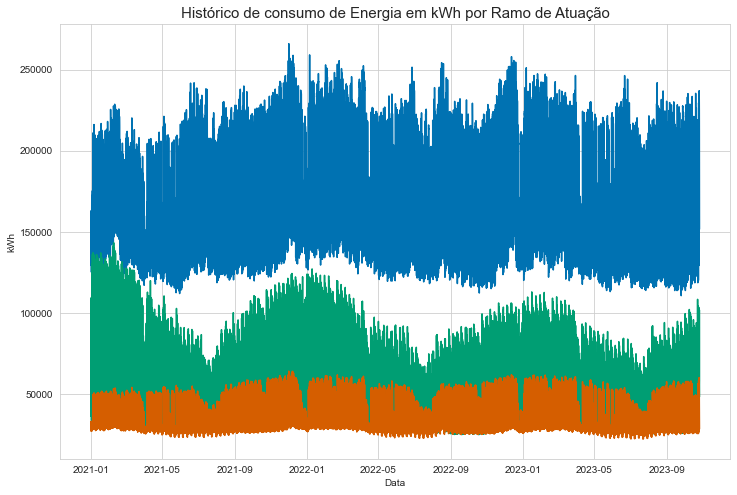

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['Meio Industrial'], ax = ax)
sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['Meio Privado'], ax = ax)
sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['Meio Público'], ax = ax)
plt.title('Histórico de consumo de Energia em kWh por Ramo de Atuação', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)


plt.show();

mlflow.log_figure(fig, 'Figure_hour_complete.png')

Podemos ver novamente que os valores medidos em ramos industriais são muito mais altos que outros. 

Porém, como estamos vendo os dados em uma resolução de horas temos que isso acaba prejudicando a visualização. Vamos selecionar uma amostra de 2 meses para ver se conseguimos perceber algum comportamento sazional.

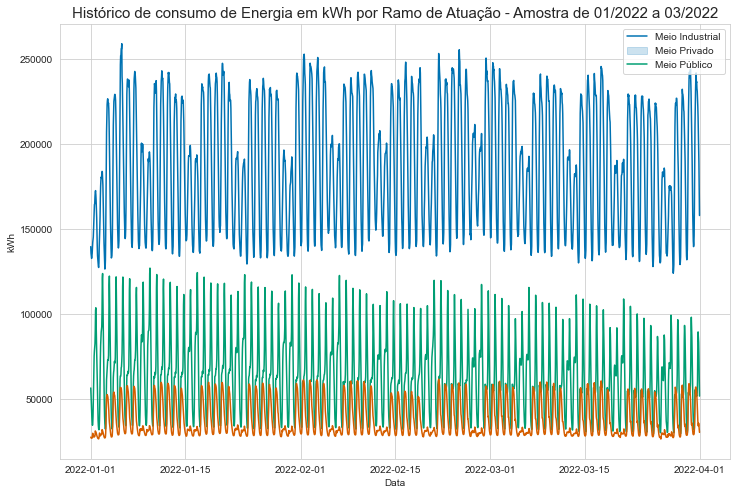

In [20]:
## Looking into a sample

df_hour_sample = df_hour['01-2022':'03-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia em kWh por Ramo de Atuação - Amostra de 01/2022 a 03/2022', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
ax.legend(df_hour.columns)

plt.show();

mlflow.log_figure(fig, 'Figure_hour_sample.png')

Podemos começar a perceber alguns padrões sazionais, aparentemente semanais, o que era de se esperar, pois o comsumo tende a ser mais frequênte durante os dias úteis e cair durante o final de semana.

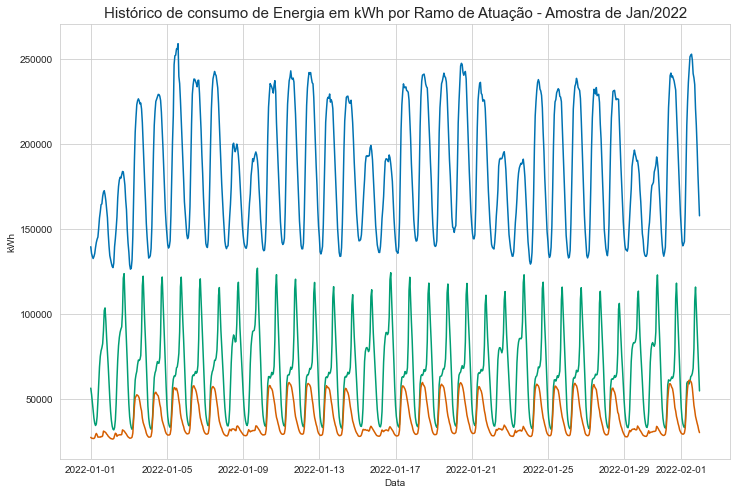

In [21]:
## Taking ONE Month

df_hour_sample = df_hour['01-01-2022':'02-01-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia em kWh por Ramo de Atuação - Amostra de Jan/2022', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)

mlflow.log_figure(fig, 'Figure_hour_sample_month.png')

Com uma amostra ainda menor fica mais sensivel ainda a questão de sazionalidade de consumo.

Percebe-se também uma comportamente levemente diferente do ramo público e privaddo. Destaque para o ramo privado, que parece ter um pico de consumo em alguns horários do dia, muito provavelmente correlacionados ao horário de trabalho

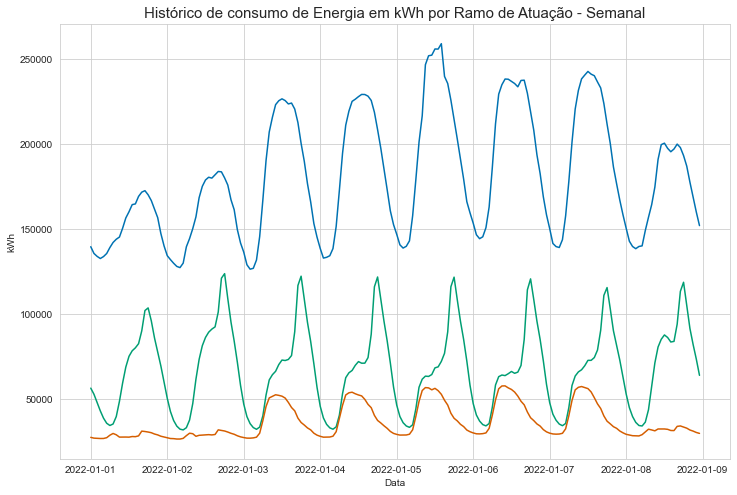

In [22]:
## Taking ONE Week

df_hour_sample = df_hour['01-01-2022':'01-08-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia em kWh por Ramo de Atuação - Semanal', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();

mlflow.log_figure(fig, 'Figure_hour_sample_week.png')

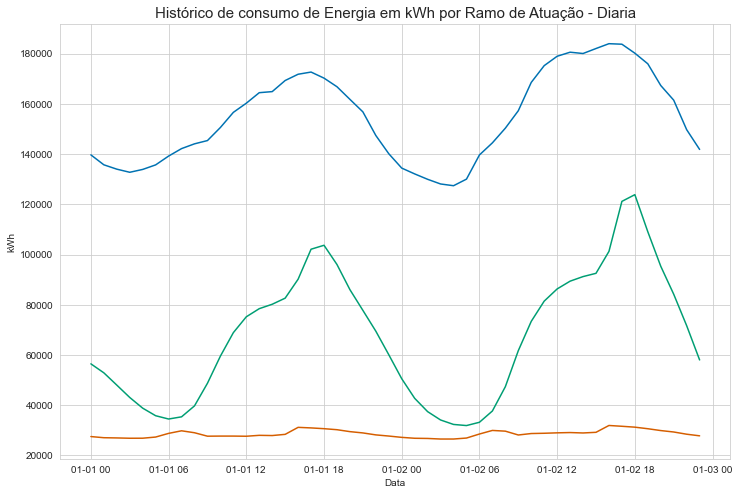

In [23]:
## Taking ONE Day

df_hour_sample = df_hour['01-01-2022':'01-02-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia em kWh por Ramo de Atuação - Diaria', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();



mlflow.log_figure(fig, 'Figure_hour_sample_day.png')

Na análise diária fica bem claro o comportamento em menor grau, avaliando o horário dos picos e vales.

#### Análise de série temporal - Dia

A análise horária é ótima para indentificar padrões de consumo em menor nível de escala. Porém, sendo o objetivo desse projeto uma previsão dos próximos dias/meses de consumo pode ser que trabalhar com a escala de horas não beneficie a modelagem.

Por esse motivo, a partir deste momento todas as análises serão realizadas avaliando o consumo diário. O consumo diário foi considerado a soma dos kWh consumidos durante todo o perído de 1 dia.



In [24]:
df_ = df.copy()

In [25]:
df_day = df_.set_index('HourDK')
df_day = pd.pivot_table(data= df_day,values = 'ConsumptionkWh', index = df_day.index, columns = 'Ramo')
df_day= df_day.resample('D').sum()
df_day

Ramo,Meio Industrial,Meio Privado,Meio Público
HourDK,,,
2021-01-01,3508699,1655305,718234
2021-01-02,3614385,1750107,693222
2021-01-03,3632312,1791945,691928
2021-01-04,4235753,1765399,900496
2021-01-05,4218881,1768095,911665
...,...,...,...
2023-10-21,3956940,1380256,682724
2023-10-22,3650936,1436290,659999
2023-10-23,4239027,1311040,939682


Armazenado a tabela no experimento para possivel futura consulta

In [26]:
mlflow.log_table(df_, 'tabela_dados_resample_day.csv')

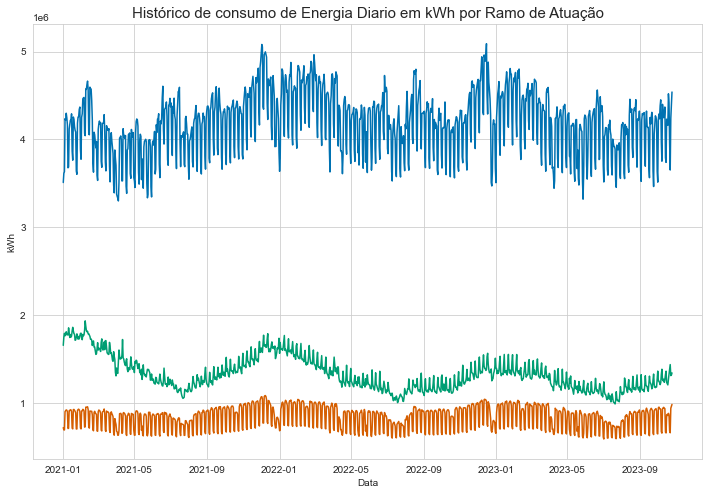

In [27]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day, x = df_day.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_day, x = df_day.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_day, x = df_day.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia Diario em kWh por Ramo de Atuação', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();

mlflow.log_figure(fig, 'Figure_day_complete.png')

Aqui os padrões não parecem tão claros. Ainda sim, conseguimos perceber uma certo comportamento de alta seguida de queda do ramo privado (Verde).

Vamos pegar uma amostra e ver como o gráfico em melhor resolução

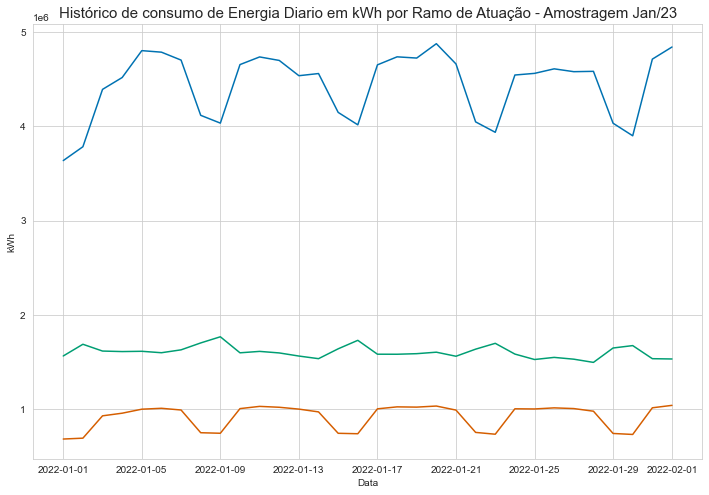

In [28]:
# Month Sample by day
df_day_sample = df_day['01-01-2022':'02-01-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia Diario em kWh por Ramo de Atuação - Amostragem Jan/23', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
# plt.legend(['Meio Industrial', 'Meio Privado', 'Meio Público'])
plt.show();


mlflow.log_figure(fig, 'Figure_day_complete_sample.png')

In [29]:
pd.DataFrame(df_day_sample.index.day_name(),df_day_sample.index).head(9)

,HourDK
HourDK,
2022-01-01,Saturday
2022-01-02,Sunday
2022-01-03,Monday
2022-01-04,Tuesday
2022-01-05,Wednesday
2022-01-06,Thursday
2022-01-07,Friday
2022-01-08,Saturday
2022-01-09,Sunday


Avaliando o período de 1 período de 1 mês alguns padrões começam a fica mais claros.

Para a série de dados do meio público percebe-se uma grande estabilidade durante os dias da semana e uma queda durante o final de semana. 

Para o ramo privado há um pico de consumo durante os domingos e sabados. Muito provavelmente isso é puxado pela demanda das pessoas comuns que durante os finais de semana saem de casa e vão a passeios, restaurantes, shows, academia e mais, puxando a alta de demanda e consequentemente a alta de consumo de energia.

Por fim, para o ramo industrial há uma forte queda de consumo durante os finais de semana. Durante os dias úteis o consumo é relativamente alto, mas não tão estável, principalmente se compardo ao ramo público

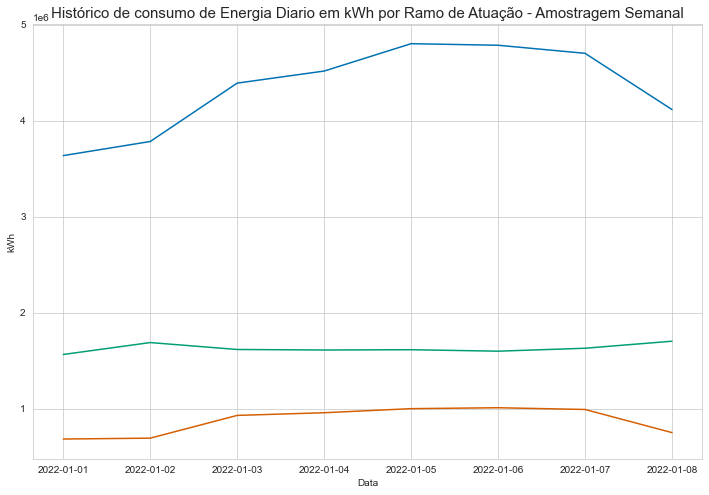

In [30]:
#Amostragem semanal
df_day_sample = df_day['01-01-2022':'01-08-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Meio Industrial', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Meio Privado', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Meio Público', ax = ax)

plt.title('Histórico de consumo de Energia Diario em kWh por Ramo de Atuação - Amostragem Semanal', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
# plt.legend(['Meio Industrial', 'Meio Privado', 'Meio Público'])
plt.show();


mlflow.log_figure(fig, 'Figure_day_complete_sample_week.png')

#### Janelas deslizantes e Comportamento Sazional

Para a melhor avaliação da série temporal vamos usar de janelas deslizantes para gerar gráficos de médias móveis.

Isso pode ser de grande valia quando queremos ver os comportamentos de forma menos ruidosa.

In [31]:
df_day

Ramo,Meio Industrial,Meio Privado,Meio Público
HourDK,,,
2021-01-01,3508699,1655305,718234
2021-01-02,3614385,1750107,693222
2021-01-03,3632312,1791945,691928
2021-01-04,4235753,1765399,900496
2021-01-05,4218881,1768095,911665
...,...,...,...
2023-10-21,3956940,1380256,682724
2023-10-22,3650936,1436290,659999
2023-10-23,4239027,1311040,939682


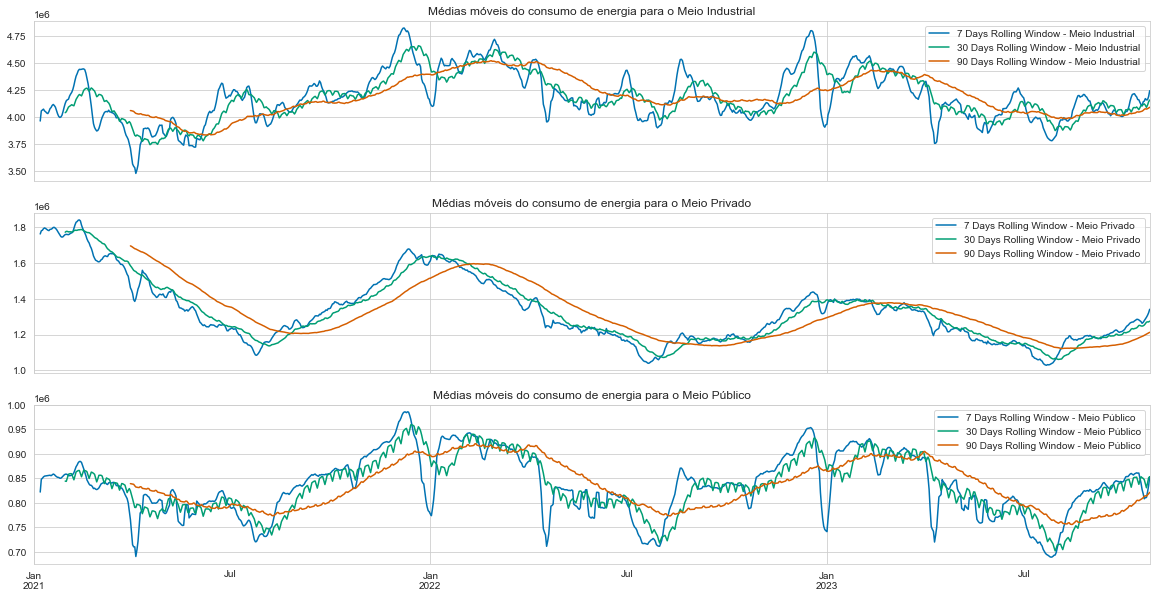

In [32]:
fig, ax = plt.subplots(nrows =3,figsize = (20,10), sharex = True)

for i, col in enumerate(df_day.columns):
    df_day[col].rolling(window= 7).mean().plot(ax = ax[i])
    df_day[col].rolling(window= 30).mean().plot(ax = ax[i])
    df_day[col].rolling(window= 90).mean().plot(ax = ax[i])
    ax[i].set_title(f'Médias móveis do consumo de energia para o {col}')
    ax[i].set_xlabel('') 
    ax[i].legend([f'7 Days Rolling Window - {col}', f'30 Days Rolling Window - {col}', f'90 Days Rolling Window - {col}'])

Como era de se esperar, uma janela deslizante maior trás uma suavização muito mais acentuada que um tempo menor. Podemos ver isso comparando os resultados da janela deslizante de 7 dias contra a de 90 dias. 

Apesar disso, em avaliações de longos períodos percebemos que os três meios tem comportamento sazional, igualando seus períodos de vales e picos na média movel de 90 dias.

Percebemos para os ramos industriais e públicos uma incidência de quedas acentuadas nos meses de Janeiro, Março e Agosto.

Fora isso, percebe-se uma estabilidade de consumo nos 2 últimos anos, sem uma tendência clara de queda ou crescimento.

Para a melhor visualização da tendências sazionais mensais, vamos agrupar os meses e avaliar comportamento similares nos anos

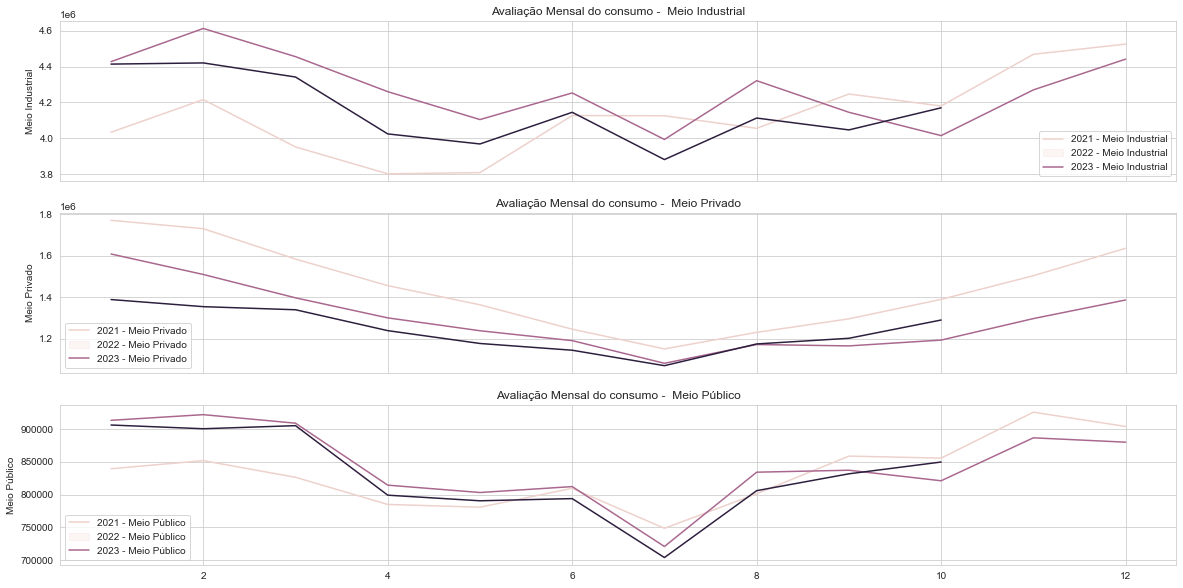

In [33]:
df_season = df_day.groupby([df_day.index.month, df_day.index.year]).mean()
df_season.index = df_season.index.set_names(['Month', 'Year'])
df_season.reset_index(inplace=True)

fig, ax = plt.subplots(nrows =3,figsize = (20,10), sharex = True)

for i, col in enumerate(df_day.columns):
    sns.lineplot(data = df_season, x = 'Month', hue='Year', y = col, ax = ax[i])
    ax[i].set_title(f'Avaliação Mensal do consumo -  {col}')
    ax[i].set_xlabel('') 
    ax[i].legend([f'2021 - {col}', f'2022 - {col}', f'2023 - {col}'])
plt.show();

Aqui fica ainda mais claro a acentuada queda de consumo nos meses de Julho, em todos os ramos de negócio.

Vamos fazer a mesma avaliação para avaliar se temos algum tipo de sazionalidade por dia

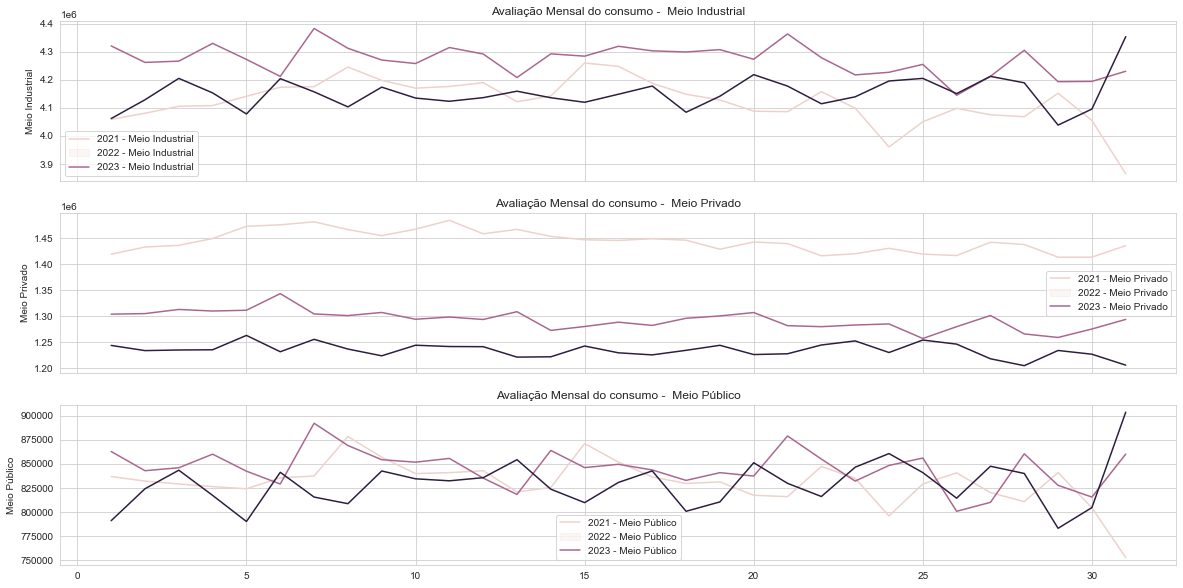

In [34]:
df_season = df_day.groupby([df_day.index.day, df_day.index.year]).mean()
df_season.index = df_season.index.set_names(['Day', 'Year'])
df_season.reset_index(inplace=True)


fig, ax = plt.subplots(nrows =3,figsize = (20,10), sharex = True)

for i, col in enumerate(df_day.columns):
    sns.lineplot(data = df_season, x = 'Day', hue='Year', y = col, ax = ax[i])
    ax[i].set_title(f'Avaliação Mensal do consumo -  {col}')
    ax[i].set_xlabel('') 
    ax[i].legend([f'2021 - {col}', f'2022 - {col}', f'2023 - {col}'])
plt.show();

Aqui sim temos um gráfico bem interessante. Para o Meio privado a estabilidade é muito grande, percebe-se que não há dias de destaque com aumento ou queda de consumo.

Para o Meio Público tem-se uma grande oscilição conforme os dias do mês vão chegando ao final do Mês. Já para o Meio industrial, embora ocorra certa oscilação, ela não chega a permitir uma conclusão bem definida.

#### Análise de Estacionariedade e Distribuição das diferenças

Um dos grandes pontos a se avaliar quando queremos prever o comportamento de uma série temporal é sua estacionariedade. Para que uma série seja considerada estacionária os seguintes requirementos são necessários:

- A série precisa ter média constante
- A série precisa ter variância constante
- Não possuir tendência

Em suma, a série precisa manter suas propriedades estatísticas mais ou menos constantes com o tempo. Podemos avaliar a estacionariedade de uma série de maneira gráfica, mas o mais recomendado é que usemos de testes estatísticos para isso!

Um dos testes mais famosos para tal é o Augmented Dickey-Fuller Test, ou ADF. Se o p-value do teste for menor que 0.05 podemos rejeitar com 95% de confiança a hipótese nula de que a série possui uma raiz unitária (E assim seria não estacionária).

Se o valor então for menor que 0.05, temos uma serie considerada estacionária.

Daqui para a frente vamos escolher apenas uma dos meios (Industrial, Público e Privado) estudado. Tudo que for desenvovido pode ser replicado para os outros dois meios ou até mesmo outra serie temporal.

Vamos escolher o meio Industrial, por ser o volume mais representativo.

In [35]:
df_day_ind = pd.DataFrame(df_day['Meio Industrial'])

In [36]:
# Vamos fazer um teste de estacionariedade para avaliar a serie temporal
results = sm.tsa.stattools.adfuller(df_day_ind)
print(f'O resultado do p-value para o teste é de {round(results[1],5)}')

O resultado do p-value para o teste é de 0.00559


O valor obitido foi muito próximo do valor desejado de 0.05, mas ainda superior a ele. Uma das formas de tornar uma série estacionária é diferenciar os seus dados, por padrão testamos a primeira diferenciação, mas outros métodos de transformação (Log ou raiz quadrada) também podem ser usados.

Vamos extrair a primeira diferenciação e testar a estacionariedade da série novamente. Após isto vamos plotar também a distribuição da série diferenciada.

In [37]:
# Vamos fazer um teste de estacionariedade para avaliar a serie temporal
results = sm.tsa.stattools.adfuller(df_day_ind.diff(1).dropna())
print(f'O resultado do p-value para o teste é de {round(results[1],10)}')

O resultado do p-value para o teste é de 0.0


Agora sim! Serie devidamente estacionária. Vamos dar uma olhada nos resíduos.

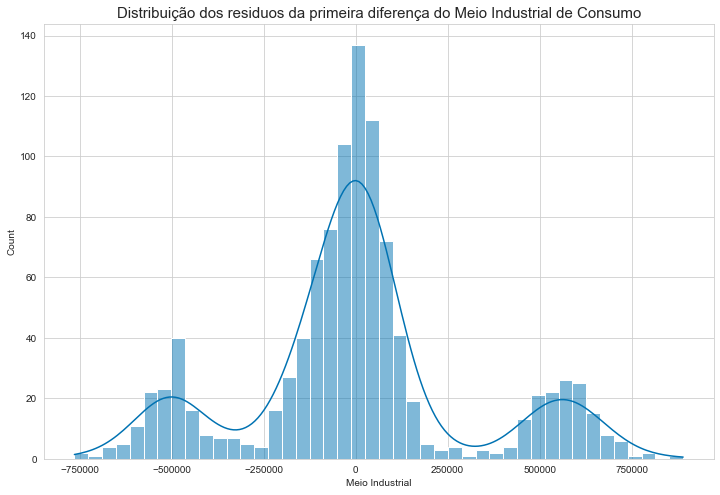

In [38]:
#Histogram of the first difference
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df_day_ind.diff(1).dropna(), x = 'Meio Industrial', kde = True)
plt.title('Distribuição dos residuos da primeira diferença do Meio Industrial de Consumo', fontsize=15)
plt.show()

Ainda que a série se apresente como escionária segundo o ADF percebemos que os resíduos tem duas tendências que diferem de zero, sendo uma positiva e outra negativa.

### 6. Modelagem e Predição da Serie Temporal via ARIMA e SARIMA

Vamos começar a explorar a modelagem e forecast de series temporais. Como dito anteriormente, há diversas maneiras de se compreender tal tarefa, mas por equanto vamos trabalhar com uma modelagem mais clássica, usando de modelos ARIMA e SARIMA para realizar a previsão de pontos futuros.

In [39]:
df_day_ind.head(2)

,Meio Industrial
HourDK,
2021-01-01,3508699
2021-01-02,3614385


Vamos pegar uma amostra mensal e rever a tendência do consumo no Meio Industrial

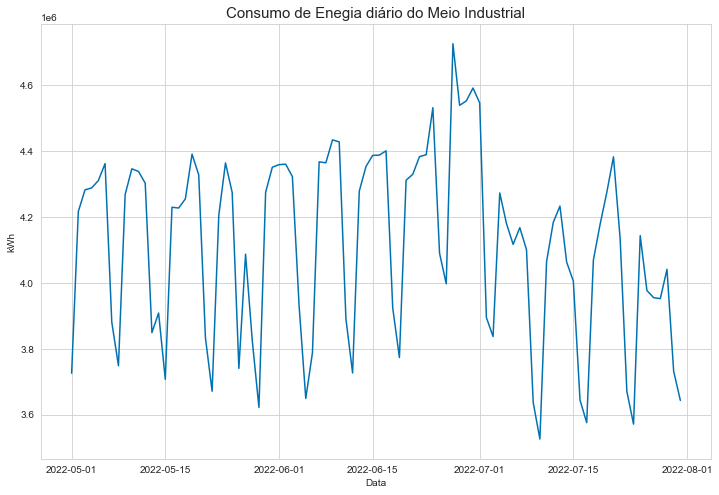

In [40]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_ind['05-2022':'07-2022'], x = df_day_ind['05-2022':'07-2022'].index, y = 'Meio Industrial', ax = ax)
plt.title('Consumo de Enegia diário do Meio Industrial', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();


Conseguimos perceber uma certa sazionalidade semanal, como dito anteriomente. 

Vamos diferenciar e ver como esses mesmos dados se comportam

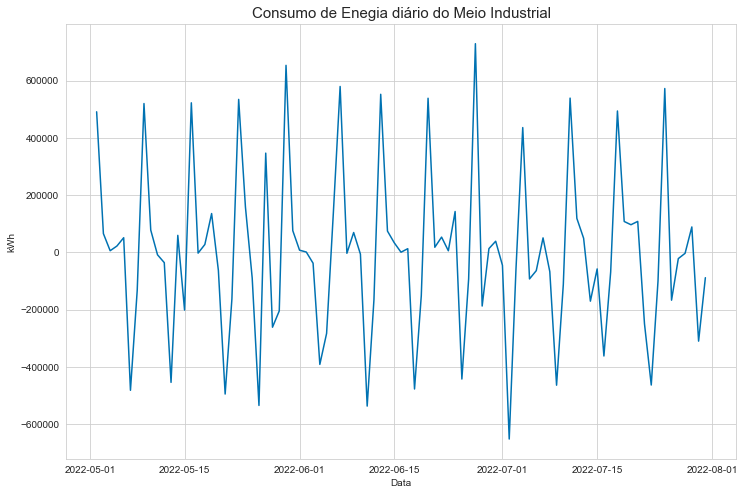

In [41]:
df_day_ind_sample_diff = df_day_ind['05-2022':'07-2022'].diff(1).dropna()

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_ind_sample_diff, x = df_day_ind_sample_diff.index, y = 'Meio Industrial', ax = ax)
plt.title('Consumo de Enegia diário do Meio Industrial', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();


Agora sim, a sazionalidade semanal fica ainda mais clara com os picos acentuados a cada 7 dias

#### Decomposição de Série Temporal

Vamos decompor a serie temporal para obter sua tendência, sazionalidade e Resíduo

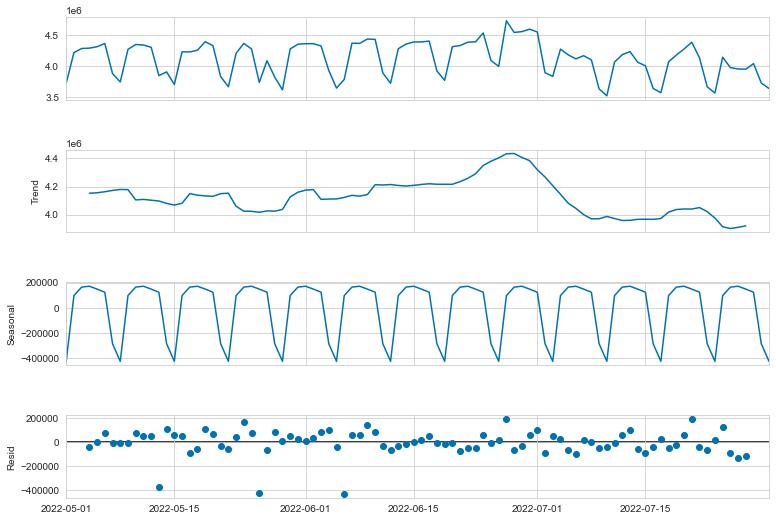

In [42]:
# Time Series Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# fig,ax = plt.subplots()
result = seasonal_decompose(df_day_ind['05-2022':'07-2022'], model='additive', period = 7)
fig = result.plot()
fig.set_size_inches(12,8)
plt.show()

mlflow.log_figure(fig, 'decomposition.png')

Muito legal, conseguimos ver que a série realmente possuiu uma sazionalidade semanal! Vamos dar uma olhada na decomposição da serie diferenciada

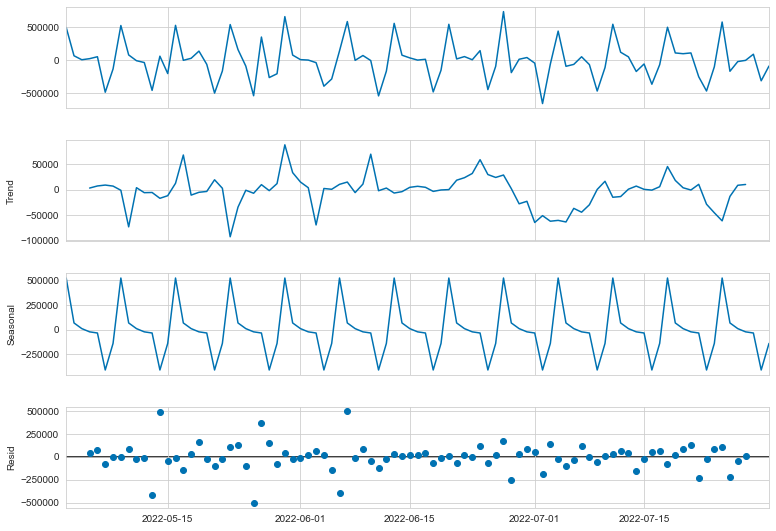

In [43]:
# fig,ax = plt.subplots()
result = seasonal_decompose(df_day_ind_sample_diff, model='additive', period = 7)
fig = result.plot()
fig.set_size_inches(12,8)
plt.show()


Podemos ver ainda mais claramente a sazionalidade do modelo. Os resíduos também tem uma variância menor e ficam ao redor do zero, além da tendência girar em torno de zero também.

### ACF & PACF

Legal, até agora conseguimos analisar as séries temporarais e deixa-las estacionárias. Estamos seguindo mais ou menos o método Box-Jenkins para a modelagem de nossos dados. 

Vamos agora tentar descobrir os parametros p e q que melhor se ajustam ao modelo ARIMA que vamos implementar. Para isso, plotamos os gráficos ACF e PACF das séries afim de estimar esses parametros

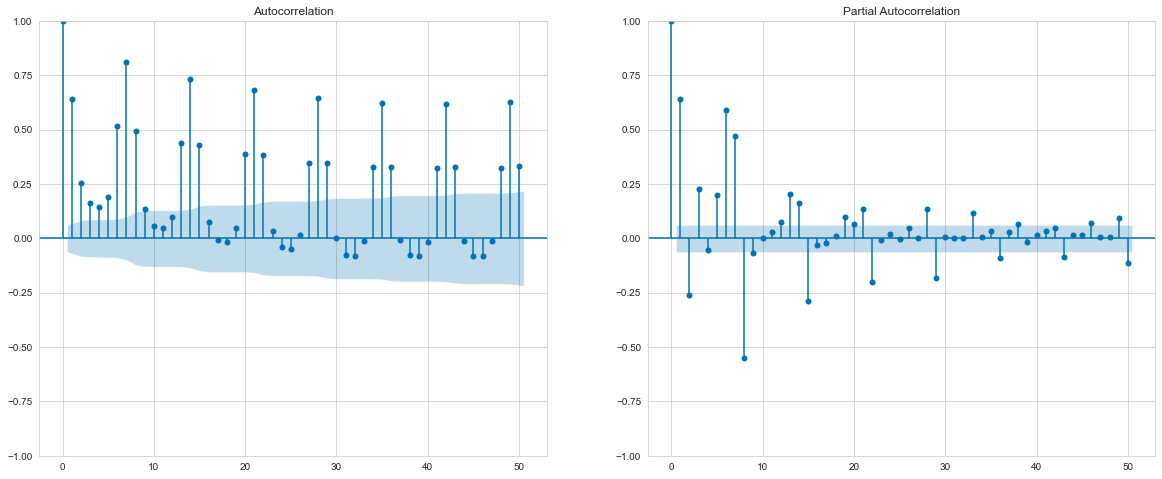

In [44]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(ncols =2, figsize=(20,8))
ax1 = sm.graphics.tsa.plot_acf(df_day_ind, lags = 50, alpha = 0.05, ax = ax[0])
ax2 = sm.graphics.tsa.plot_pacf(df_day_ind, lags = 50, alpha = 0.05, ax = ax[1])
plt.show()

O modelo parece ter uma queda moderada no gráfico ACF, mas não tem nenhum corte abrupto no PACF. Isso provavelmente indica que precisaremos de um modelo ARIMA com parametros p e q diferentes de zero. Vamos olhar os mesmos dados para a série diferenciada.

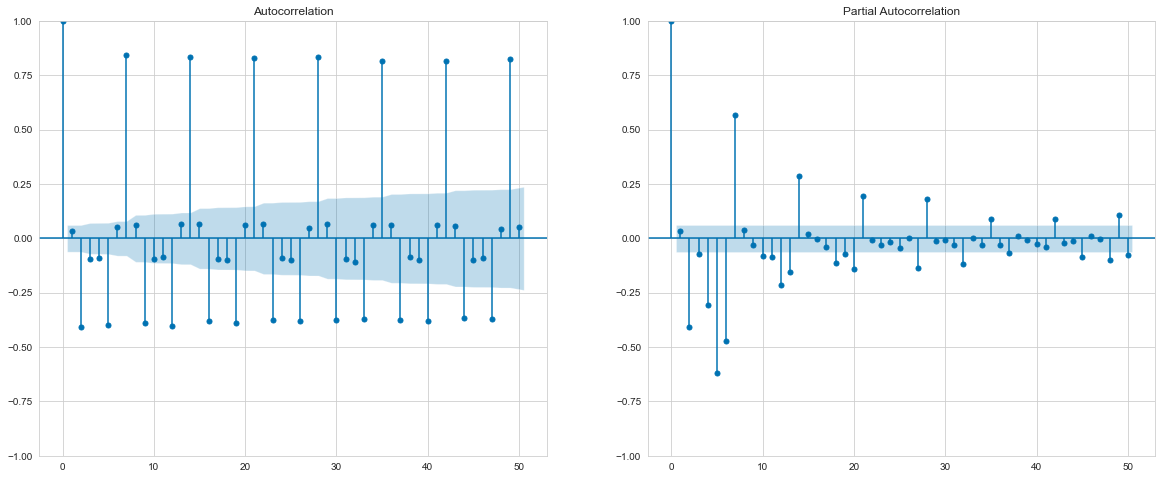

In [45]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(ncols =2, figsize=(20,8))
ax1 = sm.graphics.tsa.plot_acf(df_day_ind.diff(1).dropna(), lags = 50, alpha = 0.05, ax = ax[0])
ax2 = sm.graphics.tsa.plot_pacf(df_day_ind.diff(1).dropna(), lags = 50, alpha = 0.05, ax = ax[1])
plt.show()

Apesar de melhor, ainda não ficam claros quais os parametros q e p precisamos usar. Para a melhor resolução, vamos retirar a sazionalidade e observar novamente.

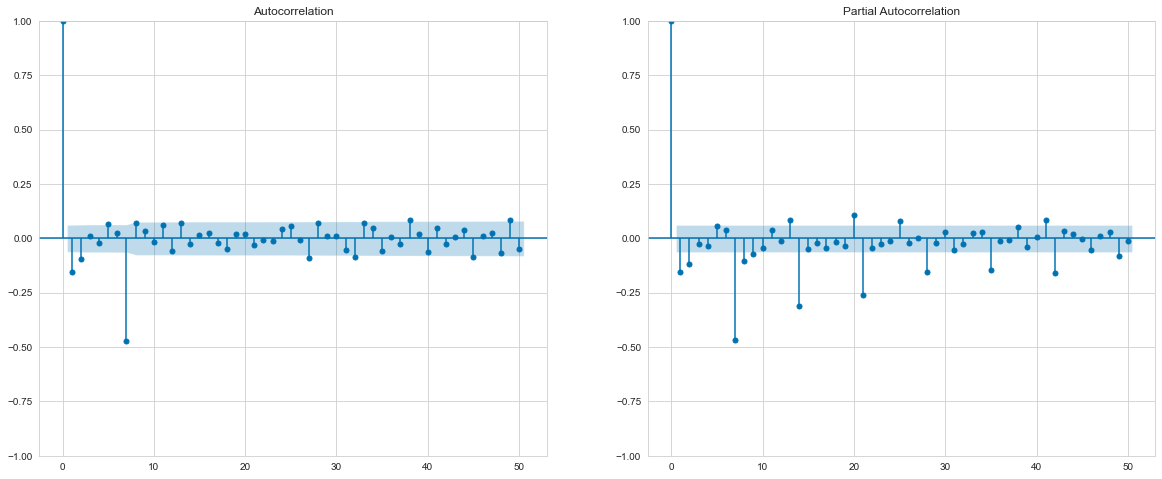

In [46]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(ncols =2, figsize=(20,8))
ax1 = sm.graphics.tsa.plot_acf(df_day_ind.diff(1).diff(7).dropna(), lags = 50, alpha = 0.05, ax = ax[0])
ax2 = sm.graphics.tsa.plot_pacf(df_day_ind.diff(1).diff(7).dropna(), lags = 50, alpha = 0.05, ax = ax[1])
plt.show()

Agora sim! Temos uma PACF apontando um corte abrupto em lag 7 e uma PACF que descresce aos poucos!

Vamos ajustar primeiramente o modelo ARIMA usando como base o AIC e rodando um for loop! Depois vamos usar o Auto ARIMA para ajustar o melhor modelo SARIMA!

Como vimos, precisamos de 1 diferenciação, então ela já será aplicada durante o for loop;

In [47]:
l = list()
for x in range(5):
    for y in range(5):
        model = sm.tsa.ARIMA(df_day_ind[:'2023-09-01'], order = (x,1,y))
        results = model.fit()
        l.append((results.aic, (x, y)))


c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\degio\anaconda3\lib\site-packages\stat

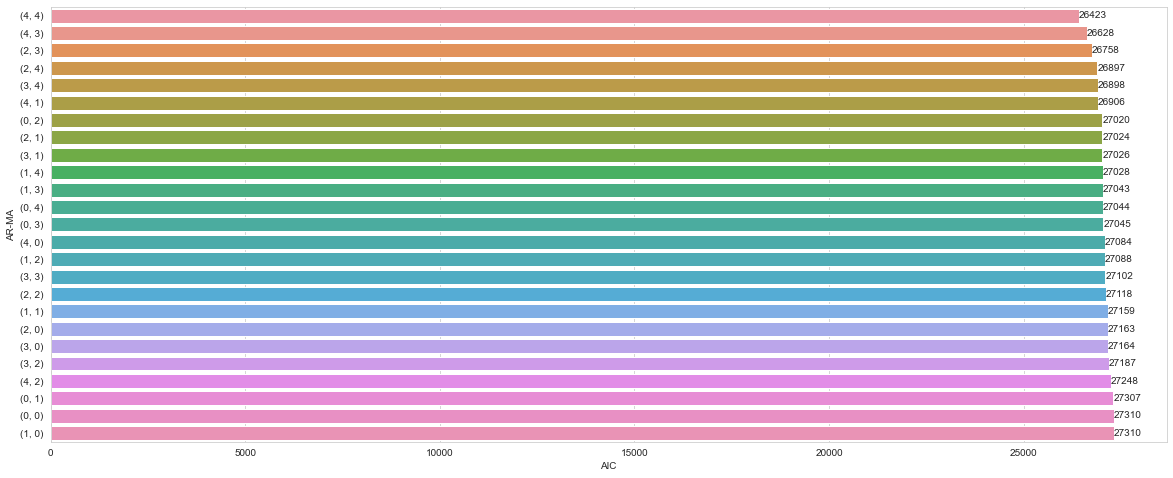

In [48]:
l = pd.DataFrame(l, columns= ['AIC', 'AR-MA'])
plt.figure(figsize = (20,8))
ax = sns.barplot(data = l.sort_values('AIC').head(30), y = 'AR-MA', x='AIC')
ax.bar_label(ax.containers[0], fmt='%.0f');

O melhor modelo ARIMA encontrado foi o (4,1,4). Porém, perceba que modelos muito mais simples não ficaram longe dos resultados obtidos! O ideal seria testar o BIC e AIC ao mesmo tempo e ter parcimonia na escolha.

Por agora, vamos seguir com o 4,1,4 mesmo!

In [49]:
model = sm.tsa.ARIMA(df_day_ind[:'2023-09-01'], order = (4,1,4))
results = model.fit()

c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Meio Industrial   No. Observations:                  974
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -13202.318
Date:                Fri, 03 Nov 2023   AIC                          26422.637
Time:                        19:08:36   BIC                          26466.560
Sample:                    01-01-2021   HQIC                         26439.353
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7991      0.005    152.672      0.000       0.789       0.809
ar.L2         -1.4347      0.004   -333.836      0.000      -1.443      -1.426
ar.L3          0.8025      0.004    183.238      0.000       0.794       0.811
ar.L4         -0.9870      0.005   -203.111      0.000      -0.996      -0.977
ma.L1         -0.8474      0.013    -63.625      0.000      -0.873      -0.821
ma.L2          1.4286      0.017     85.864      0.000       1.396       1.461
ma.L3         -0.8480      0.018    -47.340      0.000      -0.883      -0.813
ma.L4          0.9783      0.018     55.731      0.000       0.944       1.013
sigma2       6.09e+10   6.02e-15   1.01e+25      0.000    6.09e+10    6.09e+10
===================================================================================
Ljung-Box (L1) (Q):                  37.13   Jarque-Bera (JB):                28.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.08
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.95e+41. Standard errors may be unstable.
"""

Alguns dados aqui são interessantes! O Prob(Q) que corresponde a hipotese nula de que os residuos são descorrelacionados deu maior que 0.05, então podemos seguir com tal hipótese! Porém o Prob(JB) que corresponde a hipótese de que os resíduos seguem uma distribuição normal deu 0, o que pode ser um problema para nos!

Vamos plotar a analise gráfica!

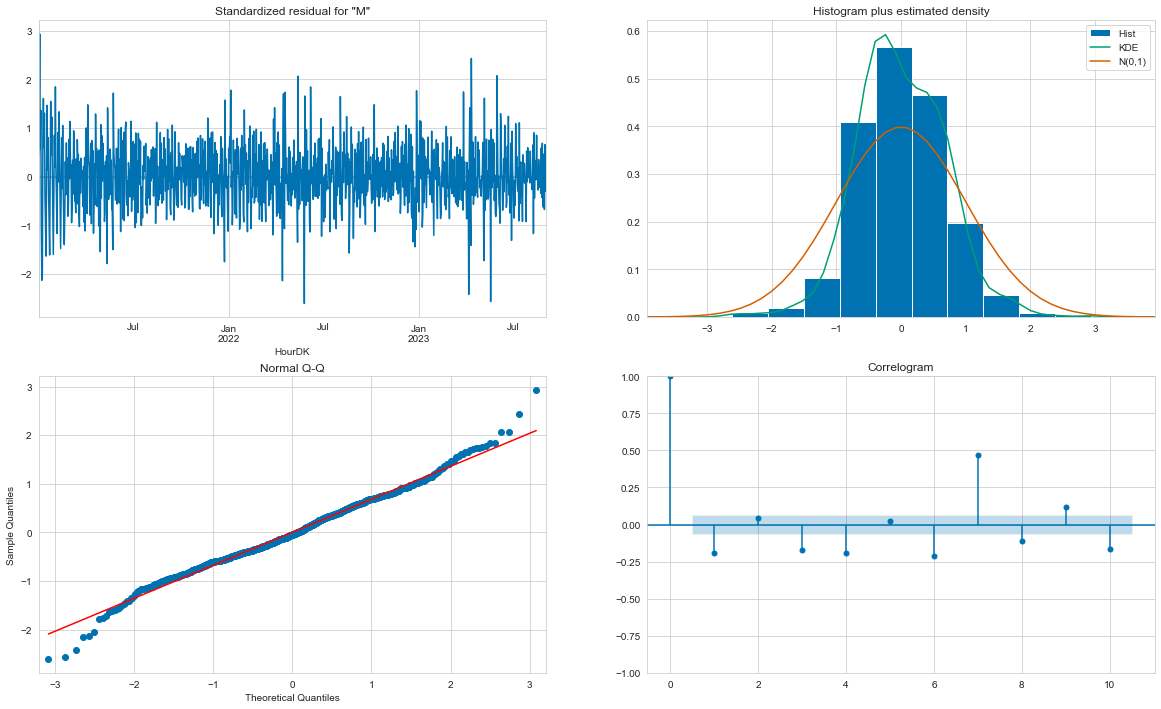

In [51]:
results.plot_diagnostics(figsize = (20,12))
plt.show();

Podemos extrair várias coisas daqui! A primeira é que a distribuição dos erros é realmente não normal! Mas o gráfico Normal Q-Q e Correalograma mostram certa dependencia do erro com pontos passados, sendo os resíduso correlacionados.

Tudo isso parece de certa forma esta ligado ao fato da serie apresentar uma sazionalidade semanal que ainda não foi imposta ao modelo! Vamos plotar a nossa base de treino e validar os resultados esperados para verificar a diferença

Fazendo o Forecast do Modelo

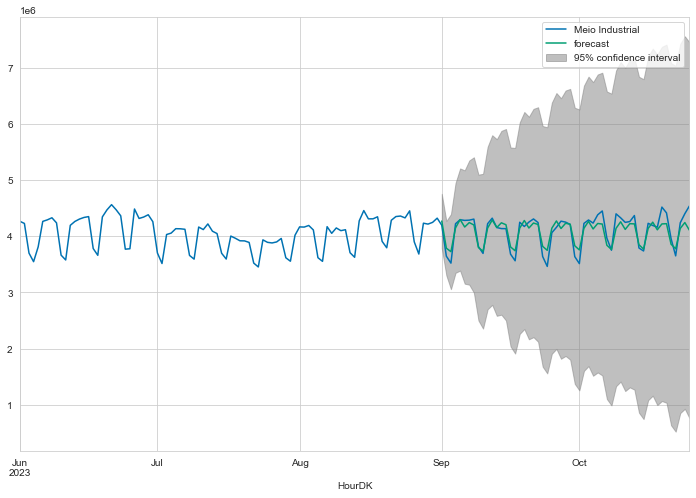

In [52]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize = (12,8))
df_day_ind['2023-06-01':].plot(ax = ax)
plot_predict(results, '2023-09-01',df_day_ind.index[-1], alpha = 0.05, ax = ax)
plt.show()

Ok! 

O modelo parece se adptar bem aos primeiros dias, mas como estamos fazendo uma previsão longa devido ao comportamento de modelos ARIMA, ele tende a jogar valor próximos a média da serie.

Vamos calcular o MAE da série prevista! Essa métrica vai ser a base de nossos estudos!

In [56]:
x_treino = df_day_ind[:'2023-09-01']

x_test = df_day_ind['2023-09-01':df_day_ind.index[-1]]
x_pred = results.get_forecast(steps = len(x_test)).predicted_mean

In [57]:
mae = mean_absolute_error(x_test, x_pred)
print(f'O valor do MAE foi de {round(mae)}')
mlflow.log_metric('MAE_ARIMA', mae)

O valor do MAE foi de 215849


Vamos agora automatizar um pouco mais nossa abordagem! Vamos usar o pdmarima para achar os melhores parametros de um modelo SARIMA de D=7 para ver se conseguimos melhorar a previsão!


In [58]:
best_model = pm.auto_arima(x_treino,
                          seasonal = True,
                          m = 7,
                          d = 1,
                          D = 1,
                          start_q = 0,
                          start_p = 0,
                          max_q = 5,
                          max_p = 5,
                          infomartion_criteria = 'aic',
                          start_Q = 0,
                          start_P = 0,
                          max_Q = 5,
                          max_P = 5,
                          trace = True,
                          stepwise = True,
                          n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=25994.300, Time=0.09 sec


c:\Users\degio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,0)(1,1,0)[7]             : AIC=25822.199, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=25657.943, Time=1.99 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=25992.689, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.57 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=25820.374, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.69 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=25596.833, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=25820.554, Time=0.21 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=2.84 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=25659.671, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=25654.866, Time=1.19 sec
 ARIMA(0,1,0)(0,1,1)[7] intercept   : AIC=25672.375, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,1,

Legal, temos o melhor modelo encontrado com base na métrica AIC de (1,1,1)(0,1,2)[7]. Vamos testar e calcular sua métrica MAE assim como avaliar as estatísticas do modelo

In [59]:
best_model

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [60]:
model = SARIMAX(x_treino, order = (0,1,0), seasonal_order = (0,1,1,7))
results = model.fit()

In [61]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Meio Industrial   No. Observations:                  974
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood              -12796.417
Date:                             Fri, 03 Nov 2023   AIC                          25596.833
Time:                                     19:11:40   BIC                          25606.580
Sample:                                 01-01-2021   HQIC                         25600.544
                                      - 09-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8568      0.013    -66.665      0.000      -0.882      -0.832
sigma2      1.846e+10   5.13e-14    3.6e+23      0.000    1.85e+10    1.85e+10
===================================================================================
Ljung-Box (L1) (Q):                   9.67   Jarque-Bera (JB):              2931.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Os reusltados de Prob(JB) ainda não são animadores. Mas vamos ver o gráficos de análise de resíduos

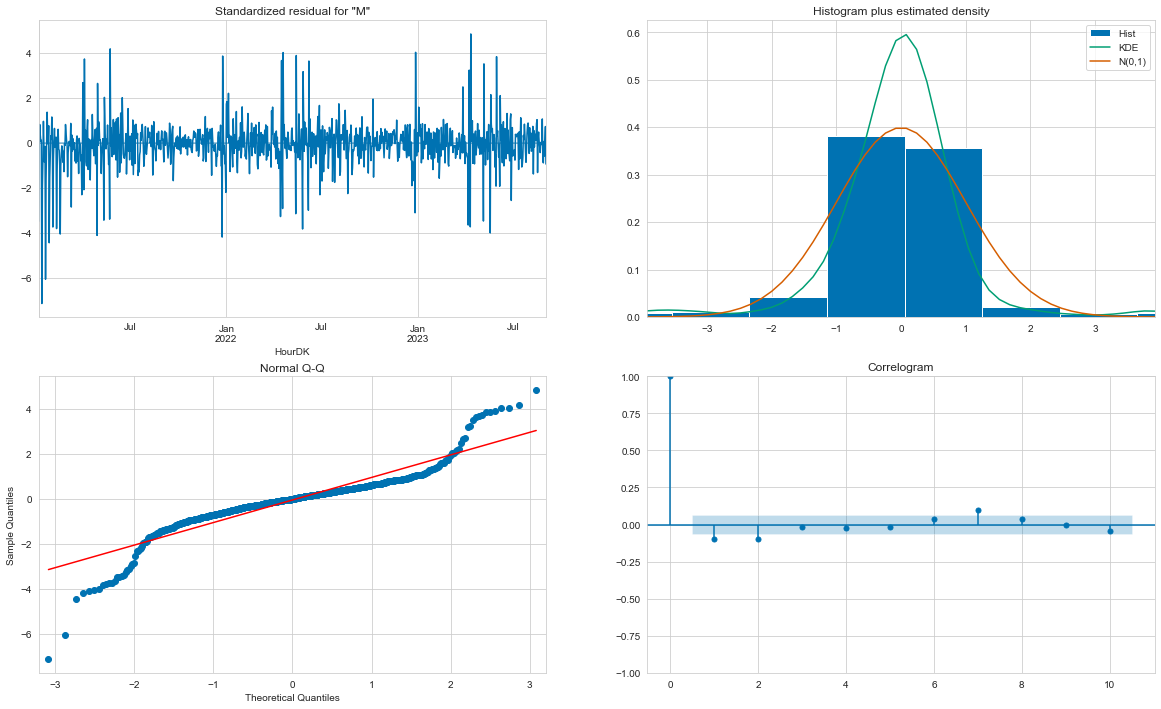

In [62]:
results.plot_diagnostics(figsize = (20,12))
plt.show();

O correlograma melhorou, porém a distribuição dos resíduos parece ter se achatado mais em comparação com uma normal. O gráfico Q-Q também desmostra um certo desvio do padrão esperado nas pontas.

Vamos fazer um forecast do modelo SARIMA

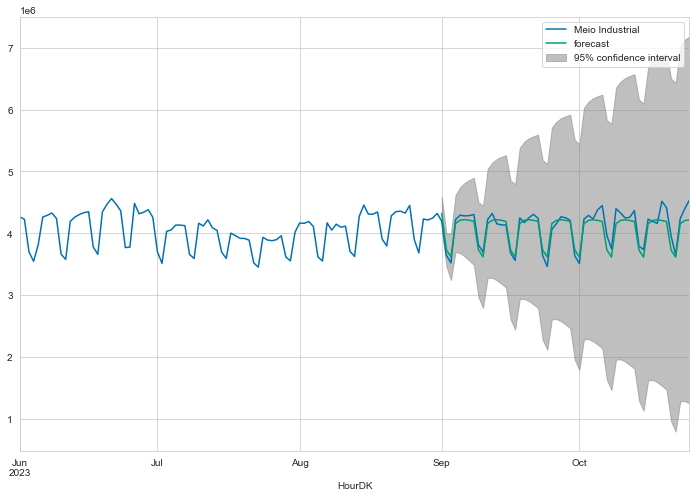

In [63]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize = (12,8))
df_day_ind['2023-06-01':].plot(ax = ax)
plot_predict(results, '2023-09-01',df_day_ind.index[-1], alpha = 0.05, ax = ax)
plt.show()

In [66]:
x_test = df_day_ind['2023-09-01':]
x_pred = results.get_forecast(steps = len(x_test)).predicted_mean

In [67]:
mae_sarima = mean_absolute_error(x_test, x_pred)
print(f'O valor do MAE foi de {round(mae_sarima)}')
mlflow.log_metric('MAE_SARIMA', mae_sarima)

O valor do MAE foi de 231754


In [68]:
mlflow.end_run()